**THIS FOLLOWS THE STEPS IN THE TUTORIAL FOUND ON https://www.tensorflow.org/tutorials/structured_data/time_series**

# Imports

In [15]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load datasets

In [16]:
import data_func.read_data as read_data
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()

# Data clean up

In [17]:
def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data[['pv_measurement', 'time']]

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train

import data_func.aggregation as data_agg
import data_func.timeseasonality as dts
from functools import reduce


time_cols = ['sinus_day', 'cosinus_day', 'sinus_year', 'cosinus_year']
average = ['clear_sky_energy_1h:J', 'prob_rime:p', 'total_cloud_cover:p']
sumation = ['direct_rad:W']
binary_featurenames = ['is_day:idx', 'is_in_shadow:idx']
categorical_featurenames = ['dew_or_rime:idx', 'precip_type_5min:idx', 'snow_drift:idx']

for i in range(len(X_frames_train)):
    df = X_frames_train[i]
    df_sum = df[['date_forecast'] + sumation]
    df_avg = df[['date_forecast'] + average]
    df_stok_med = df[['date_forecast'] + binary_featurenames]
    df_avg = data_agg.gen_agg(df_avg, 'sum')
    df_sum = data_agg.gen_agg(df_sum, 'sum')
    df_stok_med = data_agg.gen_agg(df_stok_med, data_agg.stocastic_median)
    df_merged = reduce(lambda left,right: pd.merge(left,right,on=['date_forecast'],how='outer'), [df_avg, df_stok_med, df_sum])
    df, Y_frames_train[i] = data_allign(df_merged, Y_frames_train[i])
    df = dts.append_seasonal_columns(df)
    X_frames_train[i] = df


for j in range(len(X_frames_test)):
    X_frames_test[j] = data_agg.gen_agg(X_frames_test[j], 'mean')
    X_frames_test[j] = dts.append_seasonal_columns(X_frames_test[j])
    X_frames_test[j] = X_frames_test[j][time_cols]

<Axes: title={'center': 'Train/Test  C'}, xlabel='date_forecast'>

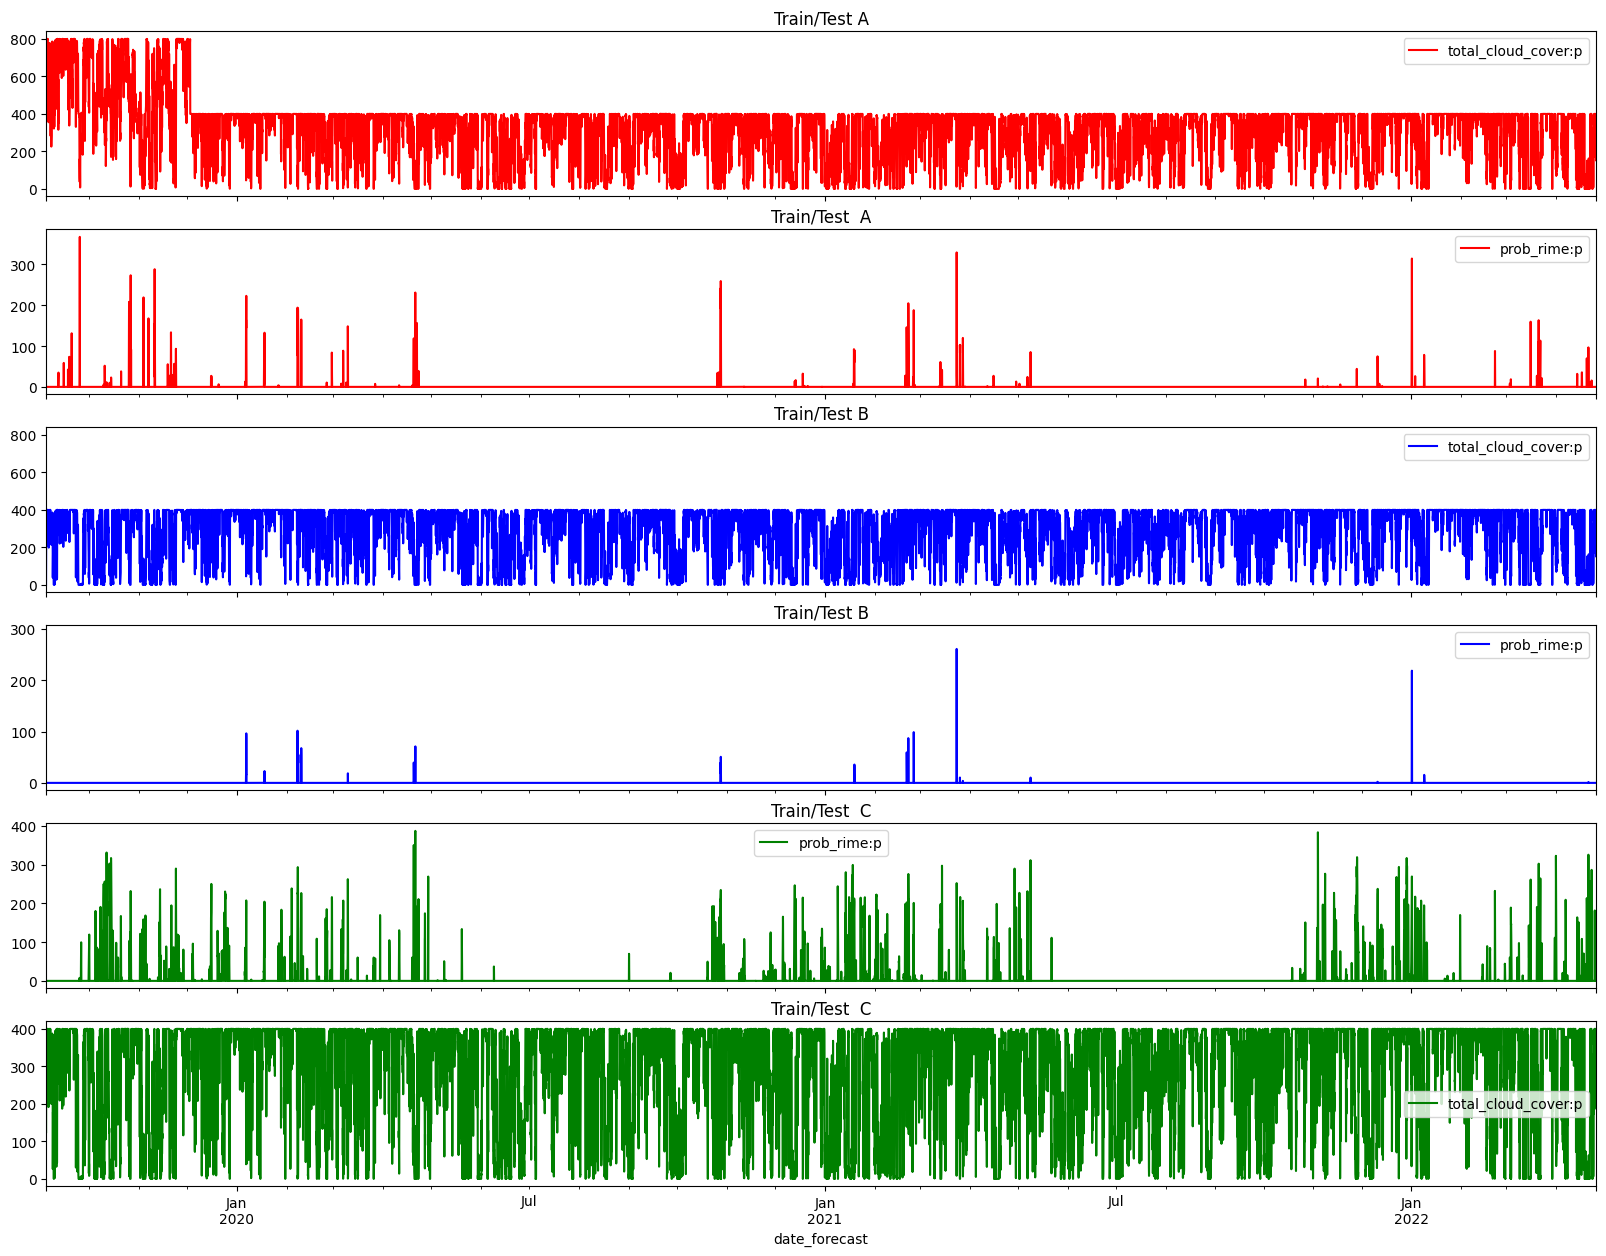

In [20]:
fig, axs = plt.subplots(6, 1, figsize=(20, 15), sharex=True)
#feature_name = 'absolute_humidity_2m:gm3'
X_frames_train[0][['date_forecast', 'total_cloud_cover:p']].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
X_frames_train[0][['date_forecast', 'prob_rime:p']].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  A', color='red')
#Y_frames_train[0].set_index('time').plot(ax=axs[1], title='Train/Test A', color='red')
X_frames_train[1][['date_forecast', 'total_cloud_cover:p']].set_index('date_forecast').plot(ax=axs[2], title='Train/Test B', color='blue')
X_frames_train[1][['date_forecast', 'prob_rime:p']].set_index('date_forecast').plot(ax=axs[3], title='Train/Test B', color='blue')
# Y_frames_train[1].set_index('time').plot(ax=axs[3], title='Train/Test B', color='blue')

X_frames_train[2][['date_forecast', 'prob_rime:p']].set_index('date_forecast').plot(ax=axs[4], title='Train/Test  C', color='green')
X_frames_train[2][['date_forecast', 'total_cloud_cover:p']].set_index('date_forecast').plot(ax=axs[5], title='Train/Test  C', color='green')
#Y_frames_train[2].set_index('time').plot(ax=axs[5], title='Train/Test C', color='green')

# Feature engineering

Need to tell the model something about how time seasonality works. E.g. night and day, as well as yearly seasonality. 

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

print(X_frames_train[0].columns)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_frames_train[0].drop(columns=['date_forecast'])))

model = tf.keras.Sequential([
    normalizer,
    #layers.Dense(10, activation='relu'),
    #layers.Dense(64, activation='relu'),
    layers.Dense(units=1)
])

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.1),
                loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
                metrics=['accuracy'])

history = model.fit(X_frames_train[0].drop(columns=['date_forecast']), Y_frames_train[0]['pv_measurement'], epochs=60, validation_split=0.2)

Index(['date_forecast', 'clear_sky_energy_1h:J', 'is_day:idx',
       'is_in_shadow:idx', 'direct_rad:W', 'sinus_day', 'cosinus_day',
       'sinus_year', 'cosinus_year'],
      dtype='object')
Epoch 1/60
742/742 [==============================] - 1s 729us/step - loss: 1449188.0000 - accuracy: 0.4671 - val_loss: 1783668.7500 - val_accuracy: 0.3419
Epoch 2/60
742/742 [==============================] - 0s 529us/step - loss: 1059273.5000 - accuracy: 0.4667 - val_loss: 1325066.1250 - val_accuracy: 0.3419
Epoch 3/60
742/742 [==============================] - 0s 527us/step - loss: 836845.8125 - accuracy: 0.4661 - val_loss: 1053565.2500 - val_accuracy: 0.3419
Epoch 4/60
742/742 [==============================] - 0s 545us/step - loss: 701361.3125 - accuracy: 0.4654 - val_loss: 883549.0000 - val_accuracy: 0.3418
Epoch 5/60
742/742 [==============================] - 0s 526us/step - loss: 604185.0000 - accuracy: 0.4648 - val_loss: 763087.4375 - val_accuracy: 0.3416
Epoch 6/60
742/742 [===========

In [6]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
55,302209.56250,0.262462,362391.34375,0.134479,55
56,302219.40625,0.261282,362277.90625,0.134816,56
57,302209.87500,0.262040,362596.81250,0.134479,57
58,302183.71875,0.259217,361469.37500,0.138692,58
59,302187.53125,0.263389,363385.65625,0.130603,59


In [7]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

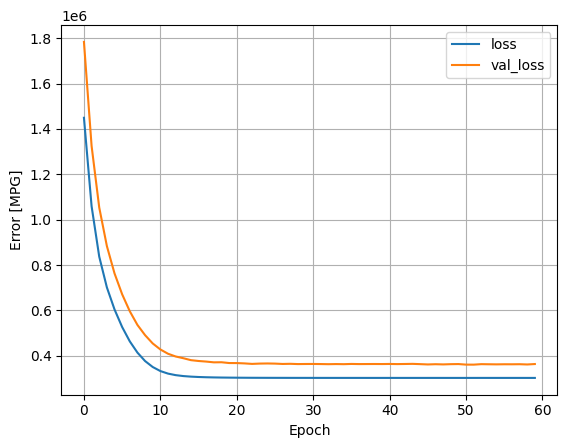

In [8]:
plot_loss(history)

157/157 [==============================] - 0s 366us/step


<Axes: title={'center': 'Train/Test A'}>

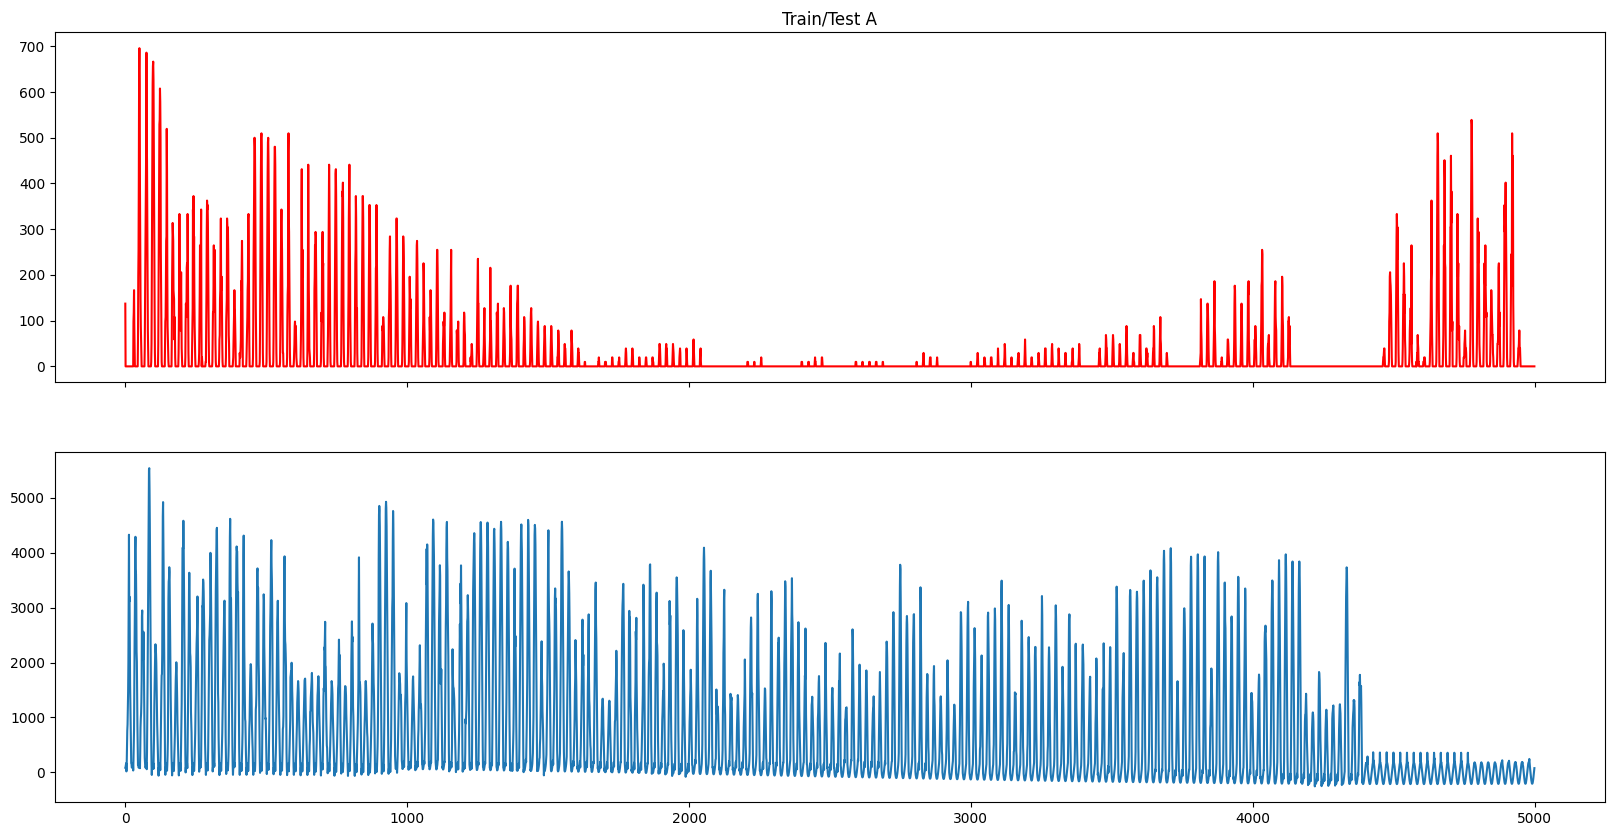

In [9]:
arr = model.predict(X_frames_train[0].drop(columns=['date_forecast'])[:5000])

#plt.plot(Y_frames_train[i], label="observed")


fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
plt.plot(arr, label = 'prediction')
Y_frames_train[i]['pv_measurement'].iloc[:5000].plot(title='Train/Test A', color='red', ax=axs[0])

### Preprocessing pipeline (not in quick)

In [ ]:
binary_featurenames = ['is_day:idx', 'is_in_shadow:idx']
categorical_featurenames = ['dew_or_rime:idx', 'precip_type_5min:idx', 'snow_drift:idx']

inputs = {}
for name, column in xta_feat.items():
  dtype = tf.float32
  inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)
inputs

In [ ]:
""" preprocessed = []

for name in binary_featurenames:
  inp = inputs[name]
  inp = inp[:, tf.newaxis]
  float_value = tf.cast(inp, tf.float32)
  preprocessed.append(float_value)

preprocessed """

In [ ]:
preprocessed = []
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
      values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

# getting numerical features
numeric_feature_names = []
for col in xta_feat.columns:
   if col not in binary_featurenames and col not in categorical_featurenames:
    numeric_feature_names.append(col)
numeric_features = xta_feat[numeric_feature_names]

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

# creating new dict to send to normalizer and append to preprocessed
numeric_inputs = {}
for name in numeric_feature_names:
  numeric_inputs[name]=inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

preprocessed

In [ ]:
""" for name in categorical_featurenames:
  vocab = sorted(set(xta_feat[name]))
  print(f'name: {name}')
  print(f'vocab: {vocab}\n')

  if type(vocab[0]) is str:
    lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
  else:
    lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

  x = inputs[name][:, tf.newaxis]
  x = lookup(x)
  preprocessed.append(x) """

In [ ]:
preprocesssed_result = tf.concat(preprocessed, axis=-1)
preprocesssed_result

In [ ]:
preprocessor = tf.keras.Model(inputs, preprocesssed_result)
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

In [ ]:
body = tf.keras.Sequential([
  tf.keras.layers.Dense(5),
  #tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [ ]:
x = preprocessor(inputs)

In [ ]:
result = body(x)

In [ ]:
model = tf.keras.Model(inputs, result)

model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
                metrics=['accuracy'])

# Training the model

In [ ]:
SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

model.fit(dict(xta_feat), target, epochs=5, batch_size=BATCH_SIZE)


# Make predictions

In [ ]:
# Do some more stuff

# Evaluate prediction

In [ ]:
# Evaluate the model

y_pred = []

# Create submission

In [ ]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submission.csv', index=False)